<a href="https://colab.research.google.com/github/balakrishna15/AI-ML-Projects/blob/main/AI_INT_BalaKrishna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Classification using Vision transformer**

TensorFlow Addons is a repository of additional functionality for TensorFlow, providing contributions in the form of custom operations, layers, activations, metrics, losses, and more.

In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 10.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

### Defining the data

In [ ]:
num_classes = 100

input_shape=(32,32,3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


### Modifying the shape of the dataset

In [ ]:
x_train = x_train[:500]
y_train = y_train[:500]
x_test = x_test[:500]
y_test = y_test[:500]

### Hyper parameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72  # resizing input images
patch_size = 6  # Size of the patches
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # transformer layers size
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of final classifier

### data augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

### Implementing MLP layer

In [ ]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation = tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

### patches

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches



### Displaying patches for a random image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


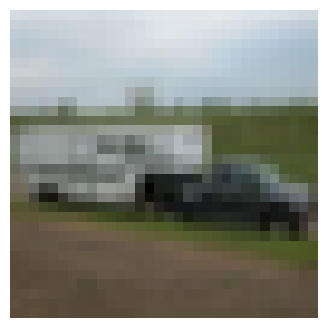

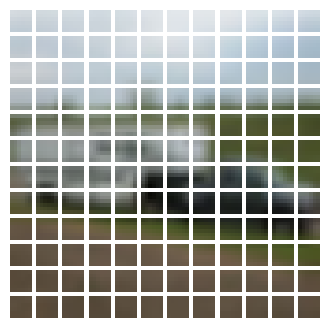

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Implementing patch encode layer

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### Building ViT model

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)   #augumented data
    patches = Patches(patch_size)(augmented)  # creating patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)  #Encoding patches
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5) # adding MLP layer

    logits = layers.Dense(num_classes)(features)

    model = keras.Model(inputs=inputs, outputs=logits)   # model creation
    return model

### Training and evaluation

In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/40
2/2 [==============================] - 49s 20s/step - loss: 6.3837 - accuracy: 0.0689 - top-5-accuracy: 0.3022 - val_loss: 4.0917 - val_accuracy: 0.2000 - val_top-5-accuracy: 0.6600
Epoch 2/40
2/2 [==============================] - 28s 13s/step - loss: 5.4624 - accuracy: 0.1822 - top-5-accuracy: 0.6133 - val_loss: 3.5543 - val_accuracy: 0.2200 - val_top-5-accuracy: 0.6800
Epoch 3/40
2/2 [==============================] - 28s 12s/step - loss: 3.9938 - accuracy: 0.2378 - top-5-accuracy: 0.6667 - val_loss: 3.0440 - val_accuracy: 0.2000 - val_top-5-accuracy: 0.6200
Epoch 4/40
2/2 [==============================] - 29s 13s/step - loss: 3.2852 - accuracy: 0.2289 - top-5-accuracy: 0.7133 - val_loss: 2.3352 - val_accuracy: 0.3200 - val_top-5-accuracy: 0.7000
Epoch 5/40
2/2 [==============================] - 27s 12s/step - loss: 2.7669 - accuracy: 0.2222 - top-5-accuracy: 0.7556 - val_loss: 2.3180 - val_accuracy: 0.2800 - val_top-5-accuracy: 0.8200
Epoch 6/40
2/2 [===================

### Testing the model

In [ ]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'frog',
    'deer',
    'dog',
    'horse',
    'ship',
    'truck',
]

In [ ]:
def img_predict(images, model):
  if len(images.shape)==3:
    out = model.predict(images.reshape(-1,*images.shape))
  else:
    out = model.predict(images)
  prediction = np.argmax(out, axis=1)
  img_prediction = [class_names[i] for i in prediction]
  return img_prediction


1/1 [==============================] - 0s 51ms/step
['dog']


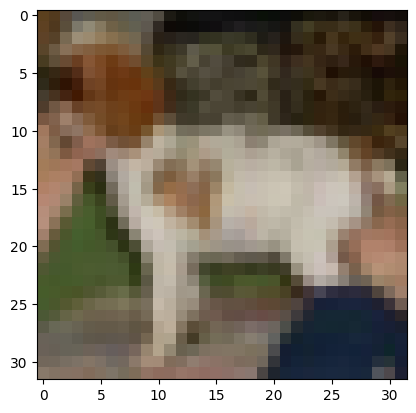

In [ ]:
index = 12
plt.imshow(x_test[index])
prediction = img_predict(x_test[index], vit_classifier)
print(prediction)